In [1]:
import pybrain
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

### Neural Networks and PyBrain

<img src="http://mechanicalforex.com/wp-content/uploads/2011/06/NN.png">

Feedforward neural network:

$$o_j^{(n)} = f\left(\sum_{i\; in\; layer (n-1)}w_{ij}o_i^{(n-1)} \right)$$

Logistic activation/transfer function:

$$f(x) = \frac{1}{1 - e^{-(x-b)}}$$

Things to fine tune for a neural network:
- number of hidden layers
- number of neurons in each layer
- learning rate
- momentum
- (bias)
- the activation function

Neural networks can be very efficient at picking up nonlinear, complex patterns that would not be recognized by simpler algorithms. This comes at the expense of a lot of engineering and fine-tuning. In general you need large datasets for the neural network to be properly trained. Too much training can lead to overfitting: the network becomes good at recognizing the entries in the training set and not the general patterns.

#### XOR Example

$$(1,1), (0,0) \rightarrow 0$$
$$(1,0), (0,1) \rightarrow 1$$

We are intereste in seeing how the function acts on the whole space $[0,1]\times [0,1]$ when we are only training it on the corners -- we get exactly the separation planes we talked about in lecture.

In [2]:
from pybrain.tools.shortcuts import buildNetwork
net = buildNetwork(2, 3, 2, bias=True)

In [3]:
from pybrain.tools.shortcuts import buildNetwork
from pybrain.datasets import SupervisedDataSet, ClassificationDataSet
from pybrain.supervised.trainers import BackpropTrainer


N = buildNetwork(2,4,1) #set the number of inputs, neurons in hidden layer (only one layer in this example), outputs

N.activate([2,1]) #forward-feed an input, returns the output of the network

array([-2.08537969])

In [4]:
def plot_nn_prediction(N): # a function to plot the binary output of a network on the [0,1]x[0,1] space
    x_list = np.arange(0.0,1.0,0.025)
    z = [0.0 if N.activate([x,y])<0.5 else 1.0 for x in x_list for y in x_list]
    z = np.array(z)
    grid = z.reshape((len(x_list), len(x_list)))
    plt.imshow(grid, extent=(x_list.min(), x_list.max(), x_list.min(), x_list.max()),cmap=plt.get_cmap('Greys_r'))
    plt.show()

before training (random network)


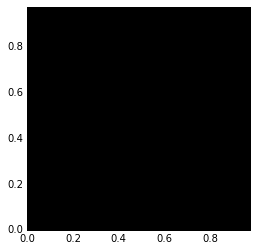

after training


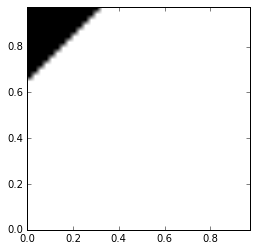

In [5]:
D = SupervisedDataSet(2,1) # define a dataset in pybrain
D.addSample([0,0],[0])
D.addSample([0,1],[1])
D.addSample([1,0],[1])
D.addSample([1,1],[0])

T = BackpropTrainer(N, learningrate=0.01, momentum=0.99) # define the trainer object and the training params

print "before training (random network)"
plot_nn_prediction(N)
T.trainOnDataset(D, 1000) # train on the dataset 1000 times
print "after training"
plot_nn_prediction(N)

#### Iris Dataset

In [6]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split

iris = datasets.load_iris()
X = iris['data']
Y = iris['target']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

n_hidden_neurons = 10

def target_vector(n): # we will use a 3-component output
    if n==0:
        return [1,0,0]
    elif n==1:
        return [0,1,0]
    else:
        return [0,0,1]

ann = buildNetwork(4, n_hidden_neurons, 3, bias=True)
trainer = BackpropTrainer(ann, momentum=0.1, verbose=False, weightdecay=0.01, learningrate=0.01)

ds_train = ClassificationDataSet(4, 3)
for i in xrange(len(X_train)):
    ds_train.addSample(X_train[i], target_vector(Y_train[i]))
    
ds_test = ClassificationDataSet(4, 3)
for i in xrange(len(X_test)):
    ds_test.addSample(X_test[i], target_vector(Y_test[i]))
    
trainer.trainOnDataset(ds_train,50) # train 50 times on the training set
    

In [7]:
def interpret_array(a):
    if max(a)==a[0]:
        return 0
    elif max(a)==a[1]:
        return 1
    else:
        return 2


y_pred = map(interpret_array, ann.activateOnDataset(ds_test))

In [8]:
from sklearn.metrics import accuracy_score

print accuracy_score(y_pred, Y_test) # accuracy on the test set

0.96


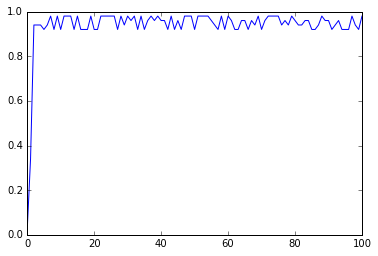

In [9]:
# examine how the network performs at each iteration of training through the training set:
ann = buildNetwork(4, n_hidden_neurons, 3, bias=True)
trainer = BackpropTrainer(ann, momentum=0.1, verbose=False, weightdecay=0.01, learningrate=0.01)
scores = [accuracy_score(map(interpret_array, ann.activateOnDataset(ds_test)), Y_test)]
for n in xrange(100):
    trainer.trainOnDataset(ds_train)
    scores.append(accuracy_score(map(interpret_array, ann.activateOnDataset(ds_test)), Y_test))
plt.plot(scores)

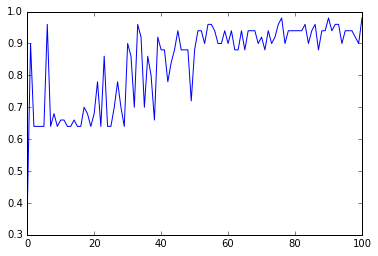

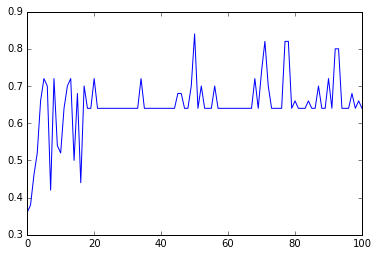

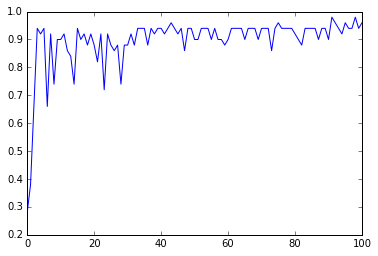

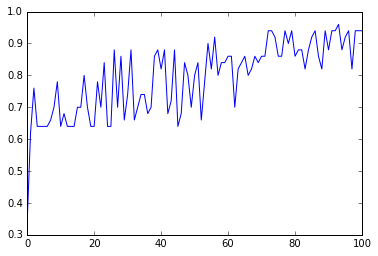

In [10]:
# a quick and dirty look at how different # of neurons in the hidden layers matters (or not)
for n_hidden_neurons in range(4,8):
    ann = buildNetwork(4, n_hidden_neurons, 3, bias=True)
    trainer = BackpropTrainer(ann, momentum=0.1, verbose=False, weightdecay=0.01, learningrate=0.01)
    scores = [accuracy_score(map(interpret_array, ann.activateOnDataset(ds_test)), Y_test)]
    for n in xrange(100):
        trainer.trainOnDataset(ds_train)
        scores.append(accuracy_score(map(interpret_array, ann.activateOnDataset(ds_test)), Y_test))
    plt.plot(scores)
    plt.show()

### Character Recognition

Character recognition in images is a classic problem solved with neural networks.

In [11]:
import sklearn
digits = sklearn.datasets.load_digits()

In [12]:
X = digits['data']
Y = digits['target']

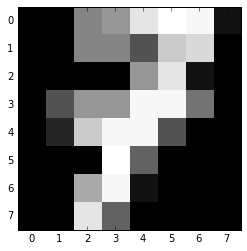

In [13]:
plt.imshow(X[7].reshape((8,8)), plt.get_cmap('Greys_r'), interpolation='nearest') #example image in the set

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)
# normalizing the dataset is good practice. You can run into float overflow with neural networks if not.
X_train = X_train/X.max() 
X_test = X_test/X.max()

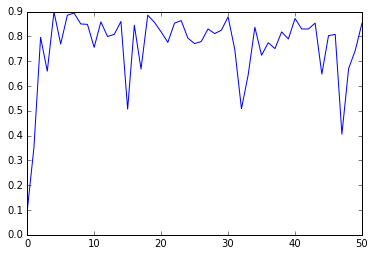

In [15]:
network = buildNetwork(64, 80, 10)

def target_list(n):
    result = [0]*10
    result[n] = 1
    return result

def target_int(a):
    return list(a).index(a.max())

def pred_score(net):
    return accuracy_score(map(target_int, net.activateOnDataset(ds_test)), Y_test)

ds_train = ClassificationDataSet(64, 10)
ds_test = ClassificationDataSet(64, 10)


ds_train.setField('input', X_train)
ds_train.setField('target', map(target_list, Y_train))


ds_test.setField('input', X_test)
ds_test.setField('target', map(target_list, Y_test))
    
trainer = BackpropTrainer(network, momentum=0.1, verbose=False, weightdecay=0.01, learningrate=0.02)

# print network.activateOnDataset(ds_test)
scores = [pred_score(network)]

for i in xrange(50):
    trainer.trainOnDataset(ds_train)
    scores.append(pred_score(network))
    
plt.plot(scores)
plt.show()


A fun account of applying deep learning:
- <a href='http://benanne.github.io/2014/08/05/spotify-cnns.html'>Spotify song recommendation algorithms</a>